Name: Ananya Praveen Shetty

Installing necessary libraries...
 Libraries installed and imported successfully.

STEP 1: DOWNLOADING AND MERGING DATASETS
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1E__Uu-WG_aZHIfA7w74wJtnXO_sABMci
To: /content/listings.csv
100% 9.65M/9.65M [00:00<00:00, 155MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=194sv-mEmXNITM-Ux4_mzYJ364F-jsRjC
To: /content/ACSDT5Y2023.B19013-Data.csv
100% 1.59M/1.59M [00:00<00:00, 29.6MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in vers

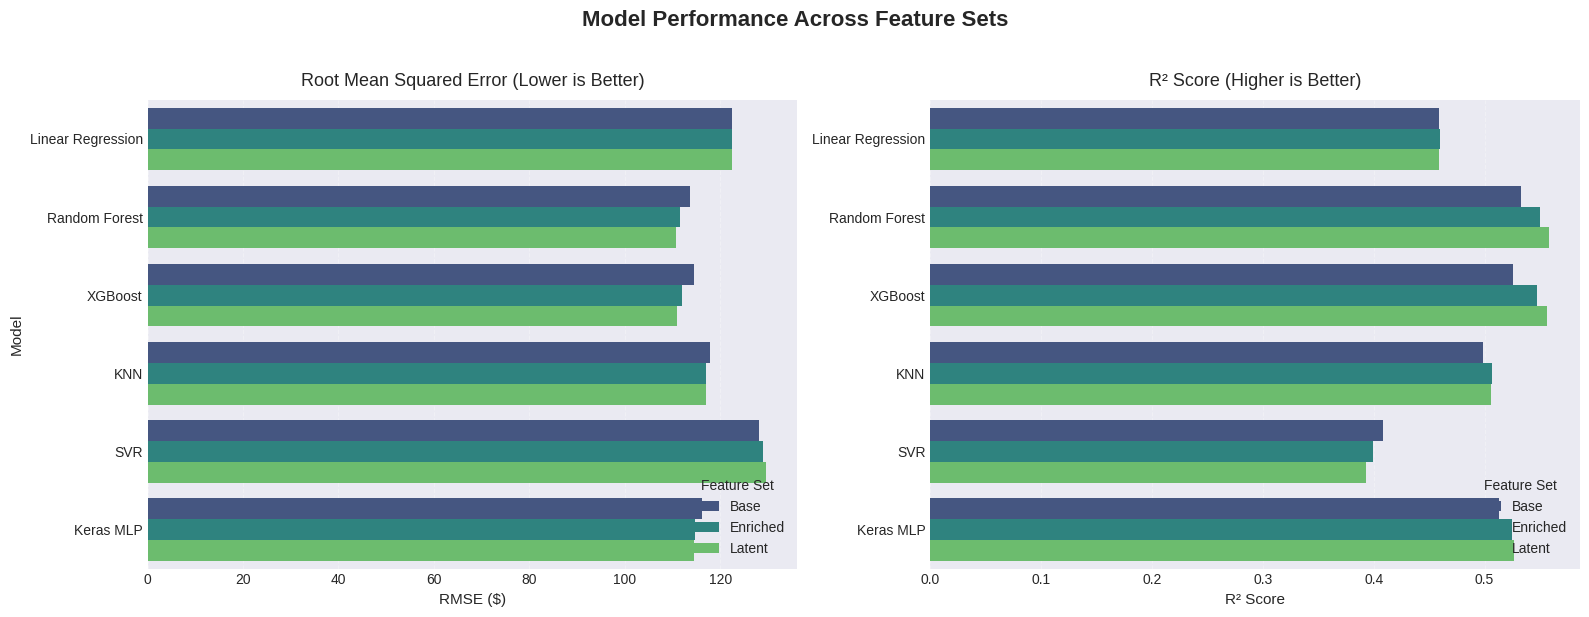

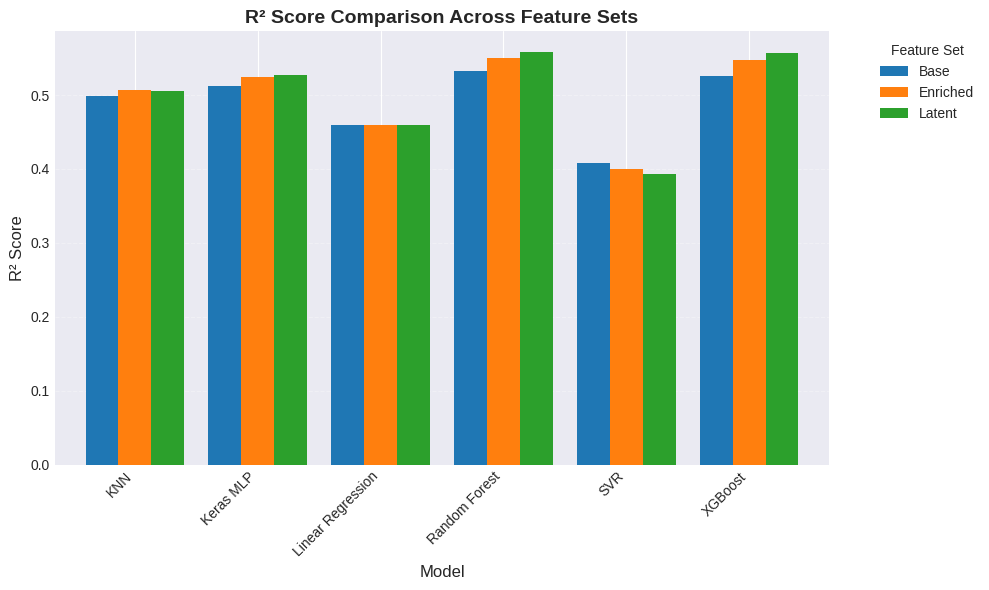

In [11]:
# @title ## Week 7: Latent Features & Regression Analysis
print("Installing necessary libraries...")
!pip install -q reverse_geocoder geopandas rtree gdown xgboost scikit-learn tensorflow

import pandas as pd
import geopandas
import reverse_geocoder as rg
import numpy as np
import warnings
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Keras for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
print(" Libraries installed and imported successfully.\n")


# =============================================================================
# STEP 1: LOAD AND MERGE DATA
# =============================================================================
print("="*80)
print("STEP 1: DOWNLOADING AND MERGING DATASETS")
print("="*80)

!gdown --id '1E__Uu-WG_aZHIfA7w74wJtnXO_sABMci' -O listings.csv
!gdown --id '194sv-mEmXNITM-Ux4_mzYJ364F-jsRjC' -O ACSDT5Y2023.B19013-Data.csv
!gdown --id '10pXS7p1yhM3Zz8R7Pspfjbn5MmixY94-' -O Walkability_Index.csv
!gdown --id '1xtR3q-pjAledua0J9AyHYw8bQq2-C2qa' -O Census_Tracts_2020.geojson

df_listings = pd.read_csv('listings.csv', low_memory=False)
df_income = pd.read_csv('ACSDT5Y2023.B19013-Data.csv')
df_walk = pd.read_csv('Walkability_Index.csv')

# Clean price column
df_listings['price'] = df_listings['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df_listings = df_listings[(df_listings['price'] > 10) & (df_listings['price'] < 1000)]

# Merge Income Data
df_income_clean = df_income.iloc[1:].rename(columns={'NAME': 'zip_code_name', 'B19013_001E': 'median_income'})
df_income_clean['zip_code'] = df_income_clean['zip_code_name'].str[-5:]
df_income_clean = df_income_clean[['zip_code', 'median_income']].copy()
df_income_clean['median_income'] = pd.to_numeric(df_income_clean['median_income'], errors='coerce')
df_income_clean.dropna(inplace=True)

coords = list(zip(df_listings['latitude'], df_listings['longitude']))
results_geo = rg.search(coords)
df_listings['zip_code'] = [result['name'] for result in results_geo]
df_merged = pd.merge(df_listings, df_income_clean, on='zip_code', how='left')

# Merge Walkability Data
gdf_tracts = geopandas.read_file('Census_Tracts_2020.geojson')
gdf_tracts['TRACT'] = gdf_tracts['CT20'].astype(int)
gdf_tracts_with_scores = gdf_tracts.merge(df_walk[['TRACT', 'Walkability']], on='TRACT', how='left')
gdf_listings = geopandas.GeoDataFrame(
    df_merged, geometry=geopandas.points_from_xy(df_merged.longitude, df_merged.latitude), crs="EPSG:4269"
)
gdf_listings = gdf_listings.to_crs(gdf_tracts_with_scores.crs)
df_final = geopandas.sjoin(gdf_listings, gdf_tracts_with_scores[['TRACT', 'Walkability', 'geometry']],
                            how="left", predicate='within')

print(f"Dataset loaded: {len(df_final)} listings")
print(f"Available columns: {df_final.columns.tolist()}\n")


# =============================================================================
# STEP 2: ENGINEER LATENT FEATURES
# =============================================================================
print("="*80)
print("STEP 2: ENGINEERING LATENT FEATURES")
print("="*80)

# Latent Feature 1: Host Experience Score
# Combines how long the host has been active with their activity level
print("Creating Latent Feature 1: Host Experience Score...")
df_final['host_since'] = pd.to_datetime(df_final['host_since'], errors='coerce')
df_final['host_days_active'] = (pd.to_datetime('2024-01-01') - df_final['host_since']).dt.days
df_final['host_days_active'] = df_final['host_days_active'].fillna(df_final['host_days_active'].median())

# Create a proxy for host activity (is_superhost as binary)
df_final['host_activity'] = df_final['host_is_superhost'].map({'t': 2, 'f': 1}).fillna(1)
df_final['host_experience_score'] = np.log1p(df_final['host_days_active'] * df_final['host_activity'])

# Latent Feature 2: Listing Popularity Score
# Combines review count with review quality
print("Creating Latent Feature 2: Listing Popularity Score...")
df_final['number_of_reviews'] = df_final['number_of_reviews'].fillna(0)
df_final['review_scores_rating'] = df_final['review_scores_rating'].fillna(df_final['review_scores_rating'].median())

# Normalize review score to 0-1 scale (assuming it's out of 5)
df_final['review_score_normalized'] = df_final['review_scores_rating'] / 5.0
df_final['popularity_score'] = np.log1p(df_final['number_of_reviews'] * df_final['review_score_normalized'])

# Latent Feature 3: Space Efficiency Score
# Ratio of guests per bedroom (how efficiently space is used)
print("Creating Latent Feature 3: Space Efficiency Score...")
df_final['bedrooms'] = df_final['bedrooms'].fillna(1)
df_final['accommodates'] = df_final['accommodates'].fillna(2)
df_final['space_efficiency_score'] = df_final['accommodates'] / (df_final['bedrooms'] + 1)

# Clean up infinities
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nLatent Features Created Successfully!")
print("\nLatent Features Summary:")
latent_cols = ['host_experience_score', 'popularity_score', 'space_efficiency_score']
print(df_final[latent_cols].describe())
print()


# =============================================================================
# STEP 3: DEFINE FEATURE SETS
# =============================================================================
print("="*80)
print("STEP 3: DEFINING FEATURE SETS")
print("="*80)

# Feature Set 1: Base Features (only from original listings)
base_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'room_type']

# Feature Set 2: Enriched Features (Base + External data)
enriched_features = base_features + ['median_income', 'Walkability']

# Feature Set 3: Latent Features (Enriched + Engineered features)
latent_features = enriched_features + ['host_experience_score', 'popularity_score', 'space_efficiency_score']

print(f"Base Features ({len(base_features)}): {base_features}")
print(f"Enriched Features ({len(enriched_features)}): {enriched_features}")
print(f"Latent Features ({len(latent_features)}): {latent_features}")
print()


# =============================================================================
# STEP 4: SETUP PREPROCESSING AND MODELS
# =============================================================================
print("="*80)
print("STEP 4: SETTING UP PREPROCESSING AND MODELS")
print("="*80)

def create_preprocessor(feature_list):
    """Create preprocessing pipeline for given features"""
    numerical_features = [f for f in feature_list if f in df_final.columns and
                         df_final[f].dtype in ['int64', 'float64']]
    categorical_features = [f for f in feature_list if f in df_final.columns and
                           df_final[f].dtype in ['object', 'category']]

    transformers = []
    if numerical_features:
        transformers.append(
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features)
        )

    if categorical_features:
        transformers.append(
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_features)
        )

    return ColumnTransformer(transformers=transformers, remainder='drop')


# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42,
                           n_jobs=-1, max_depth=6),
    "KNN": KNeighborsRegressor(n_neighbors=10, n_jobs=-1),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1)
}


def create_keras_model(input_dim):
    """Create Keras neural network"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

print("Preprocessing and models configured\n")


# =============================================================================
# STEP 5: TRAIN AND EVALUATE MODELS
# =============================================================================
print("="*80)
print("STEP 5: TRAINING AND EVALUATING MODELS (MULLER LOOP)")
print("="*80)

def train_and_evaluate(feature_set_name, features, X, y):
    """Train all models on given feature set and return results"""
    print(f"\n{'='*60}")
    print(f"Training Feature Set: {feature_set_name}")
    print(f"{'='*60}")

    results = []

    # Prepare data - only remove rows where target is missing
    X_subset = X[features].copy()
    valid_idx = y.notna()
    X_clean = X_subset[valid_idx]
    y_clean = y[valid_idx]

    # Fill remaining NaN values with median/mode (preprocessing will handle this better)
    for col in X_clean.columns:
        if X_clean[col].dtype in ['int64', 'float64']:
            X_clean[col].fillna(X_clean[col].median(), inplace=True)
        else:
            X_clean[col].fillna(X_clean[col].mode()[0] if len(X_clean[col].mode()) > 0 else 'Unknown', inplace=True)

    print(f"Valid samples: {len(X_clean)}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    # Create preprocessor
    preprocessor = create_preprocessor(features)

    # Train traditional ML models
    for name, model in models.items():
        print(f"  Training {name}...", end=" ")
        try:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model)
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            results.append({
                'Feature Set': feature_set_name,
                'Model': name,
                'RMSE': rmse,
                'R2': r2
            })
            print(f"✓ (RMSE: {rmse:.2f}, R²: {r2:.3f})")
        except Exception as e:
            print(f"✗ Error: {str(e)}")
            results.append({
                'Feature Set': feature_set_name,
                'Model': name,
                'RMSE': np.nan,
                'R2': np.nan
            })

    # Train Keras model
    print(f"  Training Keras MLP...", end=" ")
    try:
        X_train_prep = preprocessor.fit_transform(X_train)
        X_test_prep = preprocessor.transform(X_test)

        keras_model = create_keras_model(X_train_prep.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        keras_model.fit(
            X_train_prep, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred = keras_model.predict(X_test_prep, verbose=0).flatten()
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Feature Set': feature_set_name,
            'Model': 'Keras MLP',
            'RMSE': rmse,
            'R2': r2
        })
        print(f"✓ (RMSE: {rmse:.2f}, R²: {r2:.3f})")
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        results.append({
            'Feature Set': feature_set_name,
            'Model': 'Keras MLP',
            'RMSE': np.nan,
            'R2': np.nan
        })

    return pd.DataFrame(results)


# Prepare target variable
y = df_final['price']
X = df_final

# Run analysis on all three feature sets
results_base = train_and_evaluate('Base', base_features, X, y)
results_enriched = train_and_evaluate('Enriched', enriched_features, X, y)
results_latent = train_and_evaluate('Latent', latent_features, X, y)

# Combine all results
all_results = pd.concat([results_base, results_enriched, results_latent], ignore_index=True)


# =============================================================================
# STEP 6: DISPLAY RESULTS
# =============================================================================
print("\n" + "="*80)
print(" FINAL RESULTS: MODEL PERFORMANCE COMPARISON")
print("="*80)
print(all_results.to_string(index=False))
print("="*80)

# Find best performing model
best_r2 = all_results.loc[all_results['R2'].idxmax()]
best_rmse = all_results.loc[all_results['RMSE'].idxmin()]
print(f"\n Best R² Score: {best_r2['Model']} with {best_r2['Feature Set']} features (R²={best_r2['R2']:.3f})")
print(f" Best RMSE: {best_rmse['Model']} with {best_rmse['Feature Set']} features (RMSE={best_rmse['RMSE']:.2f})")


# =============================================================================
# STEP 7: VISUALIZATIONS
# =============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Remove any failed models
plot_data = all_results.dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Across Feature Sets', fontsize=16, fontweight='bold', y=1.02)

# RMSE Plot
sns.barplot(data=plot_data, y='Model', x='RMSE', hue='Feature Set', ax=axes[0], palette='viridis')
axes[0].set_title('Root Mean Squared Error (Lower is Better)', fontsize=13, pad=10)
axes[0].set_xlabel('RMSE ($)', fontsize=11)
axes[0].set_ylabel('Model', fontsize=11)
axes[0].legend(title='Feature Set', loc='lower right')
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# R² Plot
sns.barplot(data=plot_data, y='Model', x='R2', hue='Feature Set', ax=axes[1], palette='viridis')
axes[1].set_title('R² Score (Higher is Better)', fontsize=13, pad=10)
axes[1].set_xlabel('R² Score', fontsize=11)
axes[1].set_ylabel('')
axes[1].legend(title='Feature Set', loc='lower right')
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Feature importance comparison
fig, ax = plt.subplots(figsize=(10, 6))
pivot_r2 = plot_data.pivot(index='Model', columns='Feature Set', values='R2')
pivot_r2.plot(kind='bar', ax=ax, width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('R² Score Comparison Across Feature Sets', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.legend(title='Feature Set', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print("="*80)